In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import fixed


In [42]:
# Load data
data = pd.read_csv("../result_hoeffding_classifier.csv", dtype={"zip_code": str})
dynamic_window_times = pd.read_csv("movielens_dynamic_window_time_hoeffding_classifier_gender_dynamic_Tb_3_Tin_2_alpha_98_time_unit_24 hour.csv")
fixed_window_times = pd.read_csv("movielens_fixed_window_time_hoeffding_classifier_gender_per_item_alpha_98_time_unit_24 hour.csv")
fixed_window_times = fixed_window_times["fixed_window_times"].tolist()
dynamic_window_times = dynamic_window_times["dynamic_window_times"].tolist()
data_arrival_times = data["datetime"].tolist()



In [13]:
print("length of fixed window times: ", len(fixed_window_times))
print("length of dynamic window times: ", len(dynamic_window_times))
print("length of data arrival times: ", len(data_arrival_times))

length of fixed window times:  214
length of dynamic window times:  188
length of data arrival times:  100000


# arrival times of data

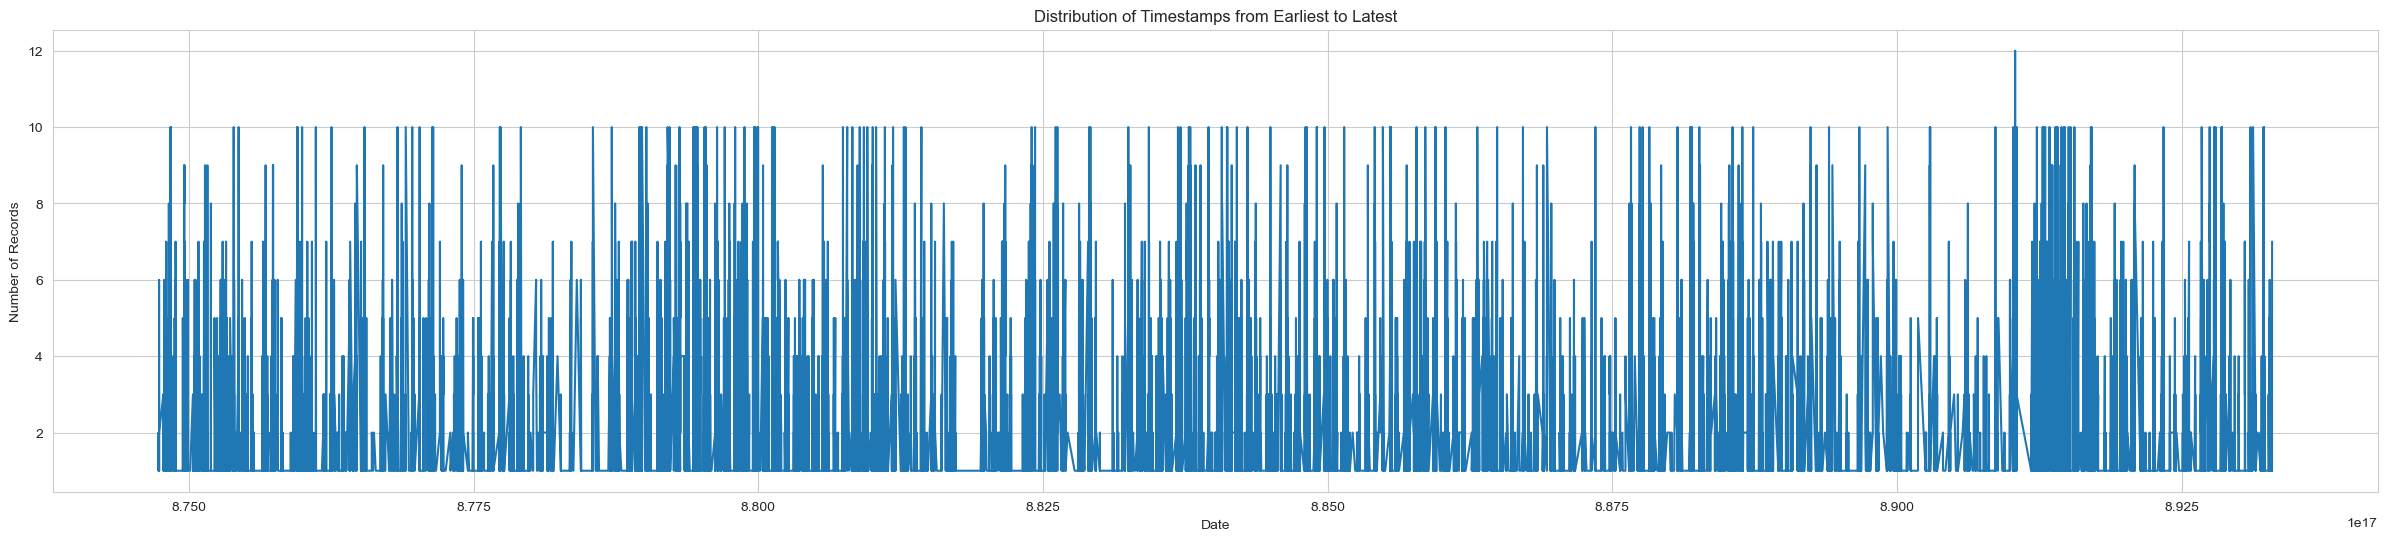

In [5]:
import matplotlib.pyplot as plt

# Group the timestamps by day, week, or month depending on your needs
timestamp_distribution = data['timestamp'].value_counts().sort_index()

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))
timestamp_distribution.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Distribution of Timestamps from Earliest to Latest')
plt.grid(True)
plt.show()

# 1. histogram frequency distribution

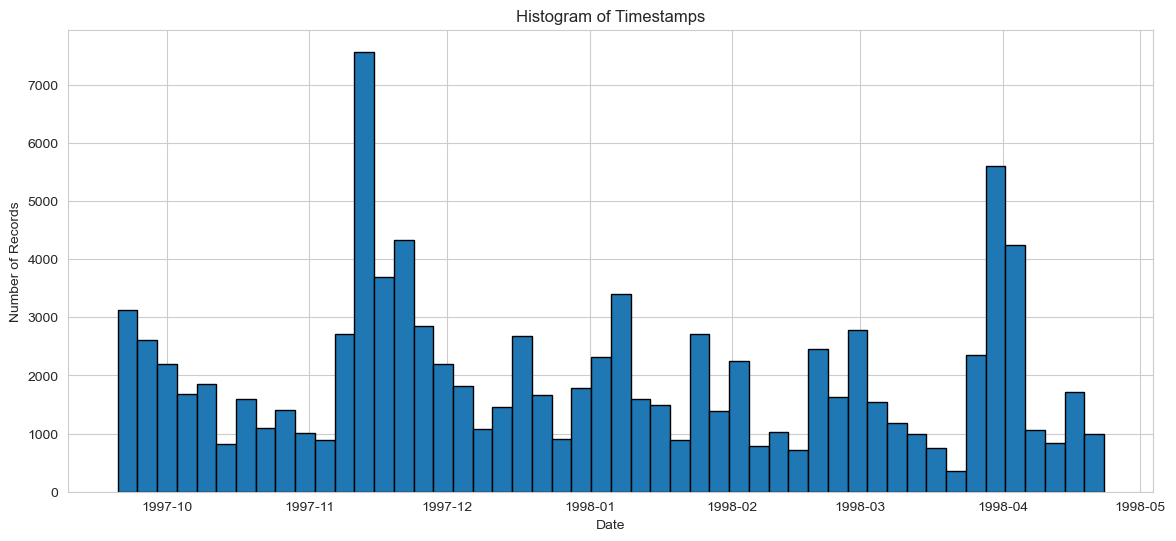

In [6]:
# Convert timestamp to datetime if not already done
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Plot histogram of timestamp counts
plt.figure(figsize=(14, 6))
plt.hist(data['timestamp'], bins=50, edgecolor='black')  # Adjust bins to control granularity
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Histogram of Timestamps')
plt.grid(True)
plt.show()


# resample data by day, week or month

## reample by day

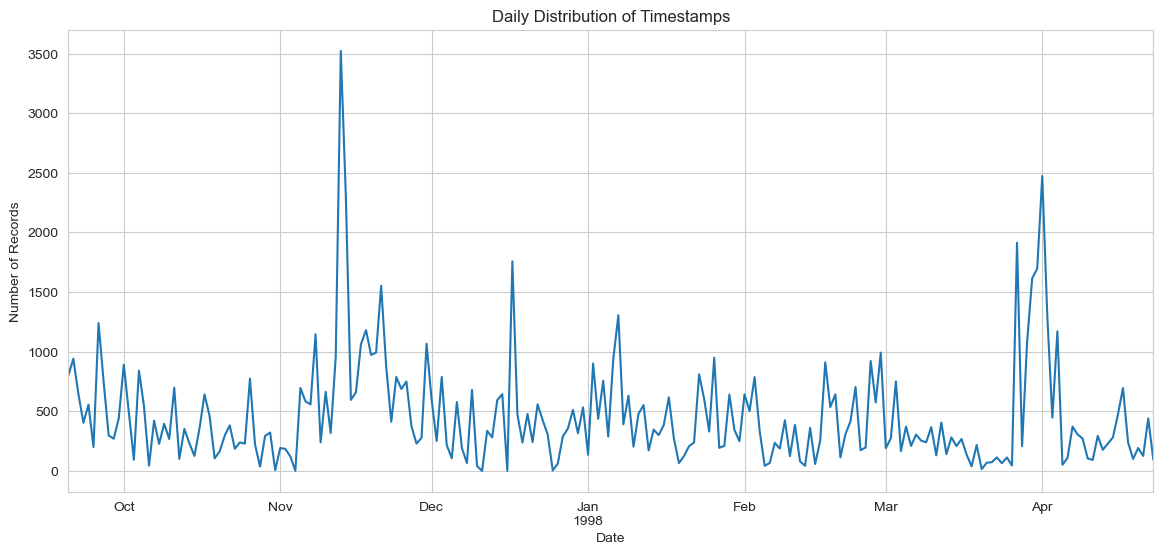

In [14]:
# Convert the 'timestamp' column to datetime if not already done
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Create a copy of the DataFrame with 'timestamp' as the index (without changing the original)
data_copy = data.set_index('timestamp', drop=False)

# Now you can resample the copy by day, week, or month without affecting the original DataFrame
daily_distribution = data_copy.resample('D').size()  # Resample by day

# Plot the daily distribution
plt.figure(figsize=(14, 6))
daily_distribution.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Daily Distribution of Timestamps')
plt.grid(True)
plt.show()

## resample by week

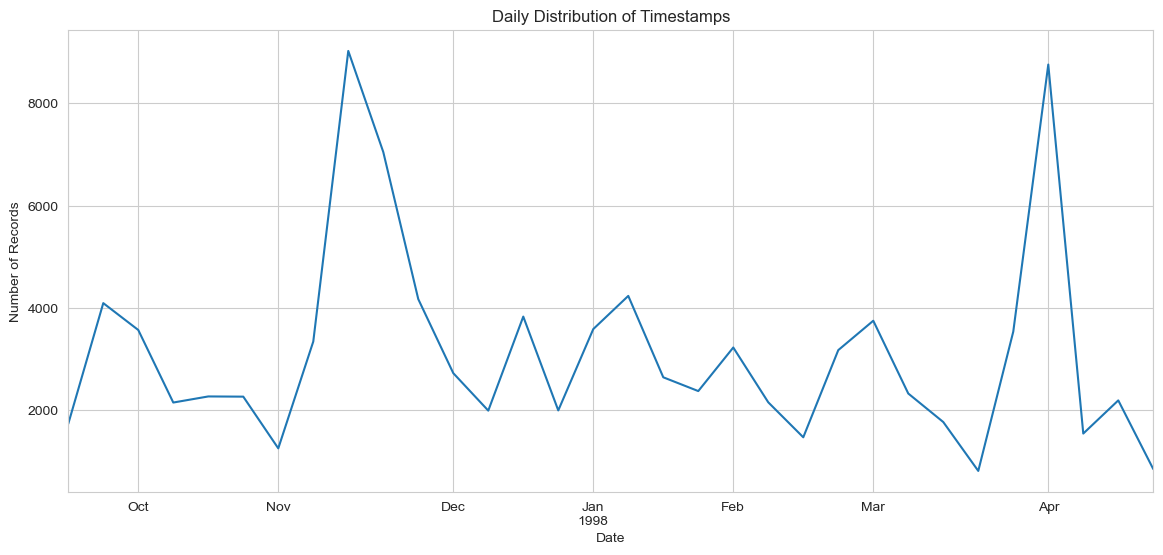

In [15]:
# Convert the 'timestamp' column to datetime if not already done
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Create a copy of the DataFrame with 'timestamp' as the index (without changing the original)
data_copy = data.set_index('timestamp', drop=False)

# Now you can resample the copy by day, week, or month without affecting the original DataFrame
daily_distribution = data_copy.resample('W').size()  # Resample by day

# Plot the daily distribution
plt.figure(figsize=(14, 6))
daily_distribution.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Daily Distribution of Timestamps')
plt.grid(True)
plt.show()

# density plot (KDE plot)

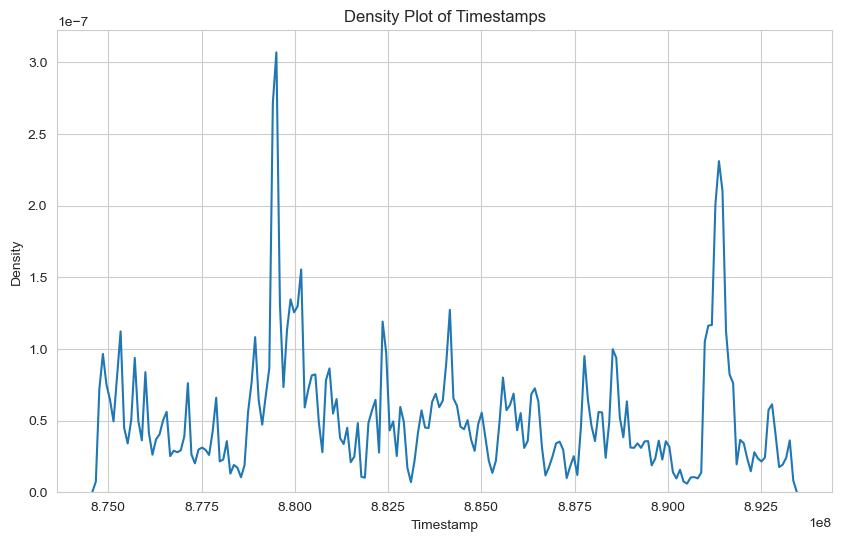

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(data['timestamp'].astype(int) / 10**9, bw_adjust=0.1)  # Convert to seconds for KDE
plt.xlabel('Timestamp')
plt.ylabel('Density')
plt.title('Density Plot of Timestamps')
plt.grid(True)
plt.show()
# 
# Bandwidth (bw_adjust): Adjusting the bandwidth (bw_adjust) can control the smoothness of the density curve. You can experiment with values to get the desired level of detail.


# bar chart for aggregated data

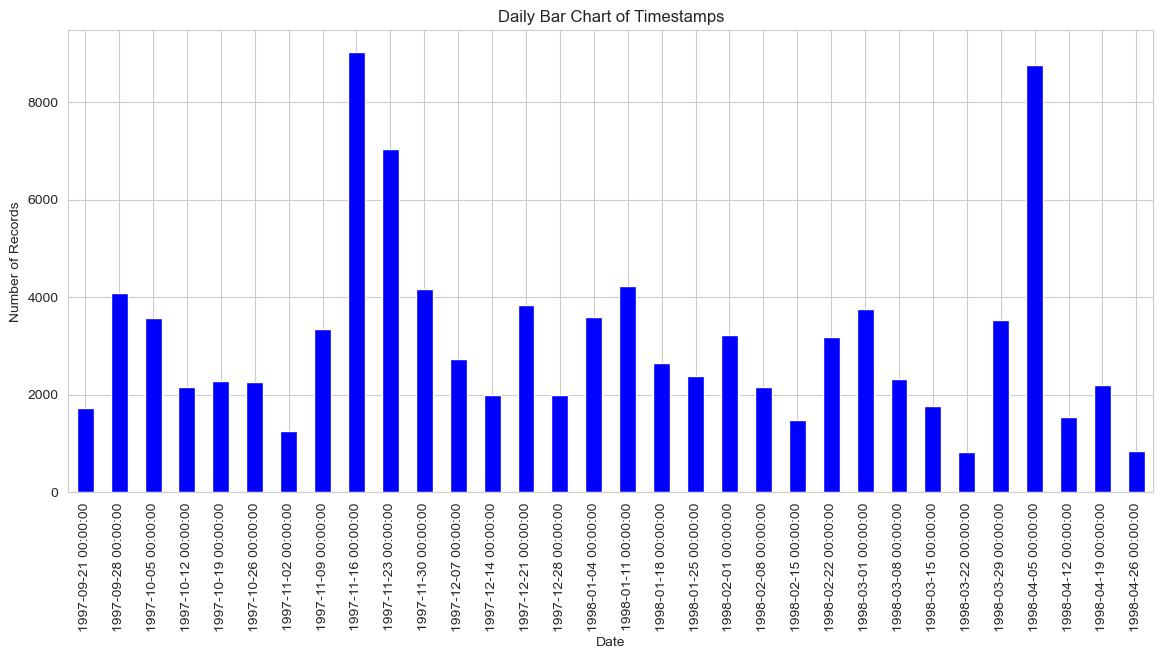

In [21]:

# Create a copy of the DataFrame with 'timestamp' as the index (without changing the original)
data_copy = data.set_index('timestamp', drop=False)
# Resample the data by day for example
daily_counts = data_copy['timestamp'].resample('W').size()


# Plot a bar chart of the resampled data
plt.figure(figsize=(14, 6))
daily_counts.plot(kind='bar', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Daily Bar Chart of Timestamps')
plt.grid(True)
plt.show()


# heatmap of data arrivals

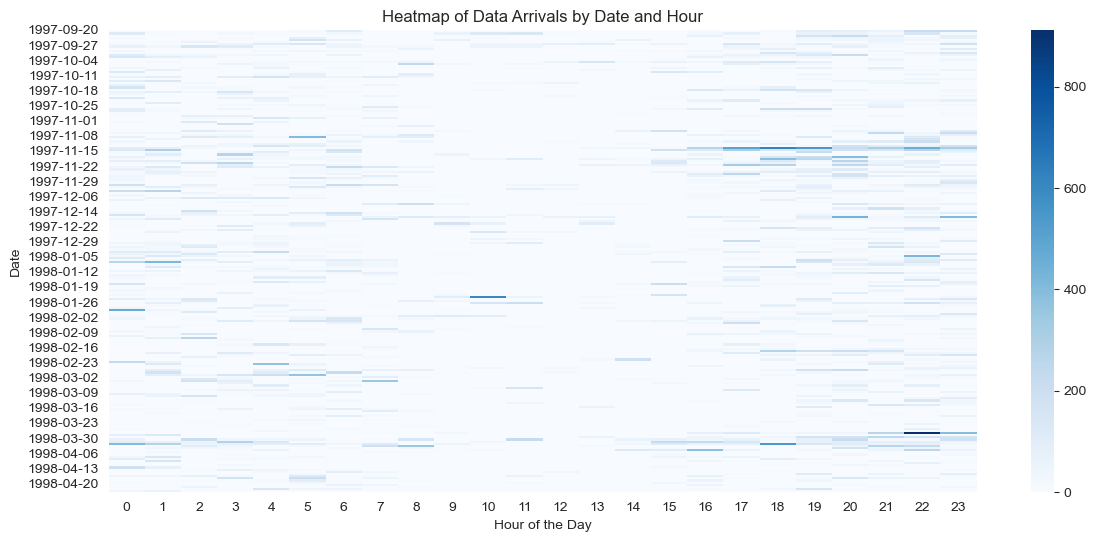

In [22]:
# Extract date and hour from the timestamps
data['date'] = data['timestamp'].dt.date
data['hour'] = data['timestamp'].dt.hour

# Create a pivot table with dates and hours
heatmap_data = data.pivot_table(index='date', columns='hour', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Blues')
plt.title('Heatmap of Data Arrivals by Date and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Date')
plt.show()


# rolling average for smoothing

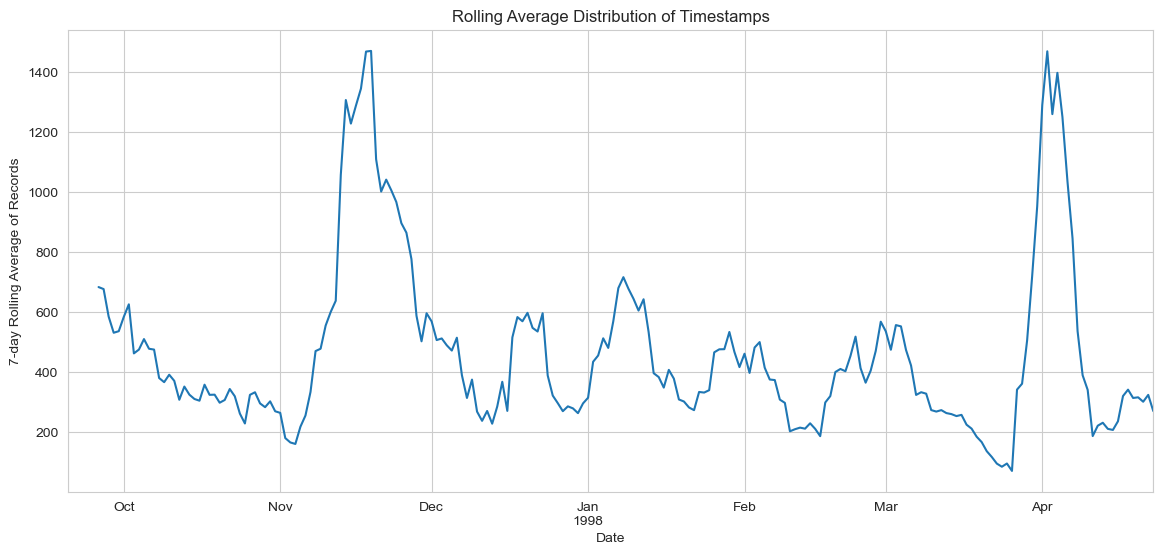

In [25]:

# Create a copy of the DataFrame with 'timestamp' as the index (without changing the original)
data_copy = data.set_index('timestamp', drop=False)
# Resample the data by day for example
daily_counts = data_copy['timestamp'].resample('W').size()

# Resample by day and apply a rolling window
rolling_distribution = data_copy['timestamp'].resample('D').size().rolling(window=7).mean()  # 7-day rolling average

# Plot the rolling distribution
plt.figure(figsize=(14, 6))
rolling_distribution.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('7-day Rolling Average of Records')
plt.title('Rolling Average Distribution of Timestamps')
plt.grid(True)
plt.show()


# data arrival gaps

To evaluate whether your time window (fixed or dynamic) makes sense in relation to the data arrival patterns, you can perform a few analyses to understand the typical behavior of the data stream. Specifically, you want to analyze:

- Data Arrival Gaps: How long is the gap between consecutive data arrivals? If data arrives continuously for 30 minutes and then stops until the next day, a 1-day window might indeed make sense.

- Burstiness: Is the data arriving in bursts, or is it spread evenly over time? This can help you determine the appropriate window size for both fixed and dynamic methods.

- Distribution of Arrival Times: Visualizing how the data arrives over time (e.g., hourly, daily, or weekly patterns) can help inform your decision on whether the window size is too small or too large.
- 
Approach
1. Analyze Gaps Between Consecutive Data Points:

Calculate the time differences (gaps) between consecutive data arrivals.
Analyze whether these gaps tend to be small (continuous arrivals) or large (sporadic bursts).

2. Visualize Data Arrival Patterns:

Use visualizations like histograms or time series plots to observe the density of data arrivals.
Compare the frequency of arrivals with your window size to see if the window makes sense.


## Step 1: Calculate Time Gaps Between Arrivals
To understand the typical gap between consecutive arrivals, you can calculate the time difference between each pair of consecutive timestamps:

In [63]:
import pandas as pd

# Load data
data = pd.read_csv("../result_hoeffding_classifier.csv", dtype={"zip_code": str})
dynamic_window_times = pd.read_csv("movielens_dynamic_window_time_hoeffding_classifier_gender_dynamic_Tb_3_Tin_2_alpha_98_time_unit_24 hour.csv")
fixed_window_times = pd.read_csv("movielens_fixed_window_time_hoeffding_classifier_gender_per_item_alpha_98_time_unit_24 hour.csv")
fixed_window_times = fixed_window_times["fixed_window_times"].tolist()
dynamic_window_times = dynamic_window_times["dynamic_window_times"].tolist()
data_arrival_times = data["datetime"].tolist()

# Convert 'timestamp' column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Calculate the time differences (gaps) between consecutive arrivals
data['time_diff'] = data['timestamp'].diff().dt.total_seconds() / 60  # Time diff in minutes

# Print the time differences
print(data[['timestamp', 'time_diff']])


                timestamp  time_diff
0     1997-09-20 05:05:10        NaN
1     1997-09-20 05:05:27   0.283333
2     1997-09-20 05:05:54   0.450000
3     1997-09-20 05:06:21   0.450000
4     1997-09-20 05:07:23   1.033333
...                   ...        ...
99995 1998-04-23 01:10:38   0.000000
99996 1998-04-23 01:10:38   0.000000
99997 1998-04-23 01:10:38   0.000000
99998 1998-04-23 01:10:38   0.000000
99999 1998-04-23 01:10:38   0.000000

[100000 rows x 2 columns]


In [82]:
# proportion of gaps smaller than 10min

def get_proportion_small_gaps(data, threshold=30):
    # Calculate the total number of gaps
    total_gaps = len(data) - 1
    data_small_gaps = data[data['time_diff'] <= threshold]
    num_small_gaps = len(data_small_gaps)
    proportion_small_gaps = num_small_gaps / total_gaps
    return total_gaps, num_small_gaps, proportion_small_gaps

total_gaps, num_small_gaps, proportion_small_gaps = get_proportion_small_gaps(data, threshold=30)
print(f"Number of gaps smaller than 10 minutes: {num_small_gaps}")
print(f"Proportion of gaps smaller than 10 minutes: {proportion_small_gaps:.2%}")



Number of gaps smaller than 10 minutes: 98507
Proportion of gaps smaller than 10 minutes: 98.51%


## Step 2: Visualize the Distribution of Gaps
Plot the distribution of time gaps to see if there’s a typical duration (e.g., 30 minutes) between data arrivals:

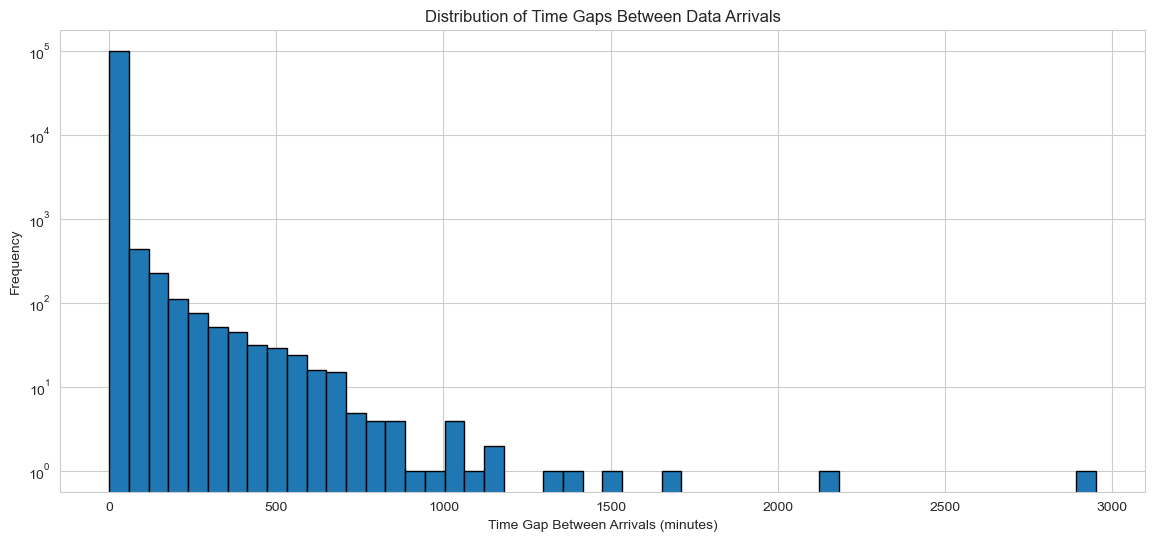

In [75]:
import matplotlib.pyplot as plt

# Drop the first row (which has NaN in time_diff due to the diff() operation)
data_gaps = data['time_diff'].dropna()

# Plot histogram of time gaps
plt.figure(figsize=(14, 6))
plt.hist(data_gaps, bins=50, edgecolor='black')
plt.xlabel('Time Gap Between Arrivals (minutes)')
plt.ylabel('Frequency')
plt.yscale("log")
plt.title('Distribution of Time Gaps Between Data Arrivals')
plt.grid(True)
plt.show()


## Step 3: Analyze if Fixed Windows Make Sense
For Fixed Windows:
If you notice that data typically arrives in bursts (e.g., every 30 minutes for a few hours and then no data for the rest of the day), a daily fixed window might make sense.
Look at the mode of the time gaps or the typical burst duration (e.g., 30 minutes, 1 hour) to see if your window size captures the data effectively.
You can visualize the data in fixed windows (e.g., 1-day windows) to confirm if the window size works well:

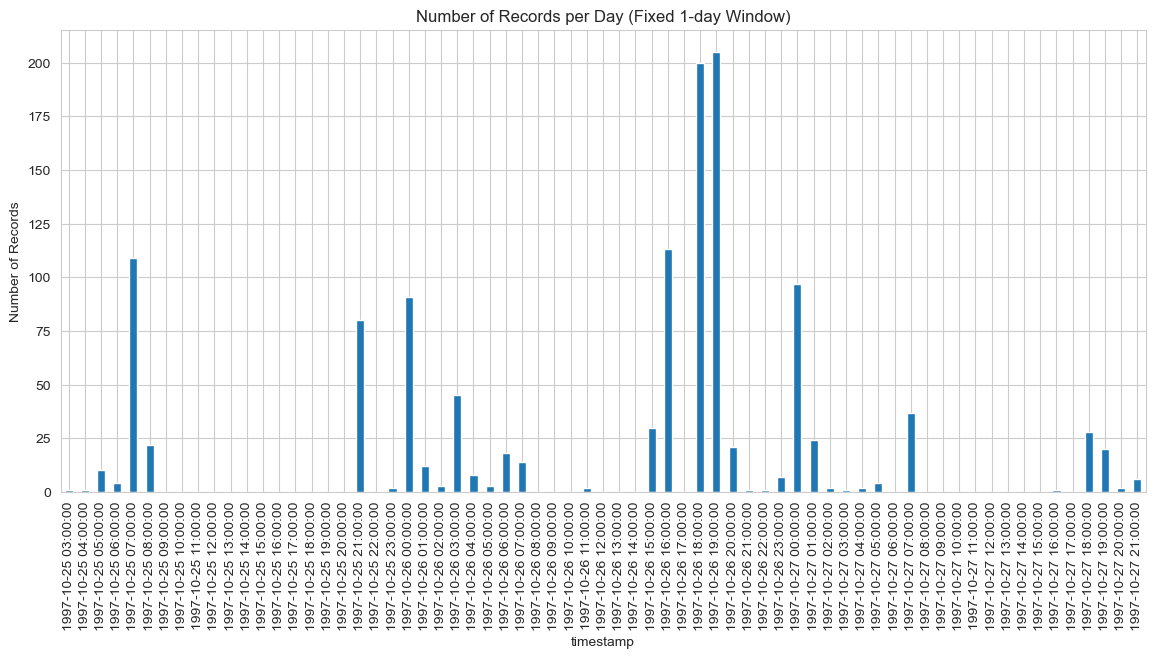

In [53]:
data = pd.read_csv("../result_hoeffding_classifier.csv", dtype={"zip_code": str})   

# Convert 'timestamp' column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Filter the data to include only records from October 1997 to November 1997
filtered_data = data[(data['timestamp'] >= '1997-10-25') & (data['timestamp'] < '1997-10-28')]


# Resample the data into 1-day windows and count the number of records per window
filtered_data.set_index('timestamp', inplace=True)
daily_distribution = filtered_data.resample('H').size()

# Plot the daily distribution
plt.figure(figsize=(14, 6))
daily_distribution.plot(kind='bar')
# plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Number of Records per Day (Fixed 1-day Window)')
plt.grid(True)
plt.show()


## Step 4: Analyze if Dynamic Windows Make Sense

### 1. Simulate Dynamic Window Resets Based on Tin and Tb

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

# Load data
data = pd.read_csv("../result_hoeffding_classifier.csv", dtype={"zip_code": str})

# Convert 'timestamp' column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Calculate time gaps between consecutive data arrivals
data['time_diff'] = data['timestamp'].diff().dt.total_seconds() / 60  # Time diff in minutes

# Parameters for dynamic window
Tin = 60  # Maximum allowed time between data points in minutes
Tb = 1440  # Maximum window length in minutes (e.g., 1 day)

# Track dynamic window resets
current_batch_start = data['timestamp'].iloc[0]
window_resets = []

for i in range(1, len(data)):
    time_gap = data['time_diff'].iloc[i]
    current_window_length = (data['timestamp'].iloc[i] - current_batch_start).total_seconds() / 60  # in minutes
    
    # Check if dynamic window should reset
    if time_gap > Tin or current_window_length > Tb:
        window_resets.append(data['timestamp'].iloc[i])  # Record reset point
        current_batch_start = data['timestamp'].iloc[i]  # Start a new batch
    
# Convert window reset times to a DataFrame for easy handling
reset_times = pd.DataFrame(window_resets, columns=['reset_time'])

# Print reset points for dynamic windows
print(reset_times)


              reset_time
0    1997-09-20 16:56:48
1    1997-09-20 18:51:26
2    1997-09-21 03:30:53
3    1997-09-21 08:45:13
4    1997-09-21 16:53:25
...                  ...
1084 1998-04-22 03:56:27
1085 1998-04-22 06:13:40
1086 1998-04-22 16:00:37
1087 1998-04-22 18:52:40
1088 1998-04-22 22:12:29

[1089 rows x 1 columns]


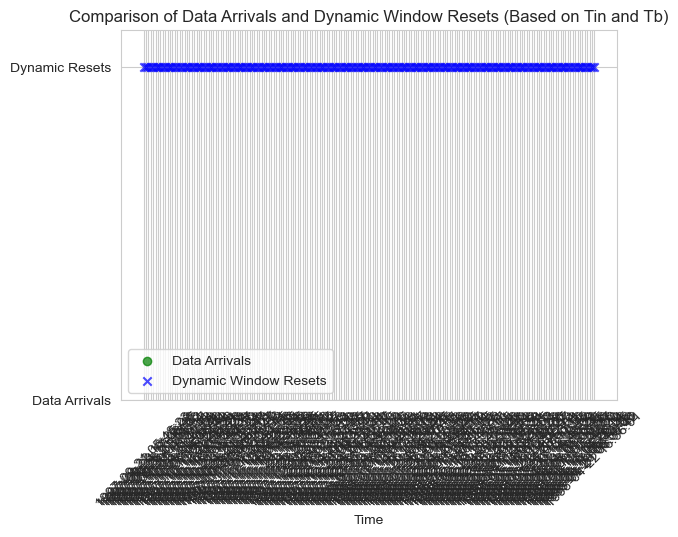

In [43]:
# Convert arrival times and reset times to numeric values for plotting
data_arrival_times_numeric = data['timestamp'].astype(int) / 10**9  # Convert to seconds for plotting
dynamic_window_times = pd.read_csv("movielens_dynamic_window_time_hoeffding_classifier_gender_dynamic_Tb_3_Tin_2_alpha_98_time_unit_24 hour.csv")

reset_times_numeric = dynamic_window_times['dynamic_window_times'].tolist()


# Plot data arrival times as green dots (y=1)
plt.scatter(data_arrival_times_numeric, [1] * len(data_arrival_times_numeric), color='green', label='Data Arrivals', marker='o', alpha=0.7)

# Plot dynamic window reset points as blue crosses (y=2)
plt.scatter(reset_times_numeric, [2] * len(reset_times_numeric), color='blue', label='Dynamic Window Resets', marker='x', alpha=0.7)

# Label the x-axis with datetime format
plt.xticks(rotation=45)
plt.yticks([1, 2], ['Data Arrivals', 'Dynamic Resets'])
plt.xlabel('Time')
plt.title('Comparison of Data Arrivals and Dynamic Window Resets (Based on Tin and Tb)')
plt.legend()
plt.grid(True)
plt.show()


### resample

In [44]:
# import pandas as pd
# import matplotlib.pyplot as plt
# 
# import pandas as pd
# 
# # Load data
# data = pd.read_csv("../result_hoeffding_classifier.csv", dtype={"zip_code": str})
# 
# # Convert the 'timestamp' column to datetime if not already done
# data['timestamp'] = pd.to_datetime(data['timestamp'])
# 
# # Create a copy of the DataFrame with 'timestamp' as the index (without changing the original)
# data_copy = data.set_index('timestamp', drop=False)
# 
# resampled_data = data_copy.resample('300T').size()
# 
# # Resample reset times by 30-minute intervals
# reset_times.set_index('reset_time', inplace=True)
# resampled_resets = reset_times.resample('300T').size()
# 
# # Plot resampled data
# plt.figure(figsize=(14, 6))
# resampled_data.plot(kind='bar', color='green', alpha=0.7, label='Data Arrivals')
# resampled_resets.plot(kind='bar', color='blue', alpha=0.7, label='Dynamic Resets')
# 
# plt.xticks(rotation=45)
# plt.xlabel('Time')
# plt.ylabel('Number of Records')
# plt.title('Resampled Data Arrivals and Dynamic Resets (30-minute intervals)')
# plt.legend()
# plt.grid(True)
# plt.show()


KeyError: "None of ['reset_time'] are in the columns"

# calculate number of sessions per user

Summary Statistics:
count    2537.000000
mean       39.416634
std        63.167566
min         1.000000
25%         2.000000
50%        14.000000
75%        47.000000
max       737.000000
Name: num_ratings, dtype: float64


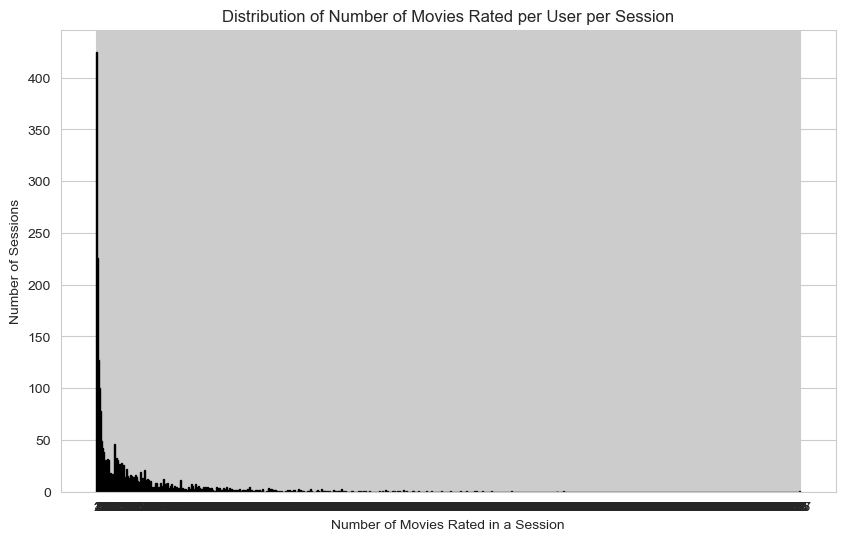


Number of Sessions by Number of Movies Rated:
1      425
2      226
3      127
4      100
5       78
      ... 
414      1
435      1
483      1
490      1
737      1
Name: num_ratings, Length: 259, dtype: int64

Average number of sessions per user: 2.69


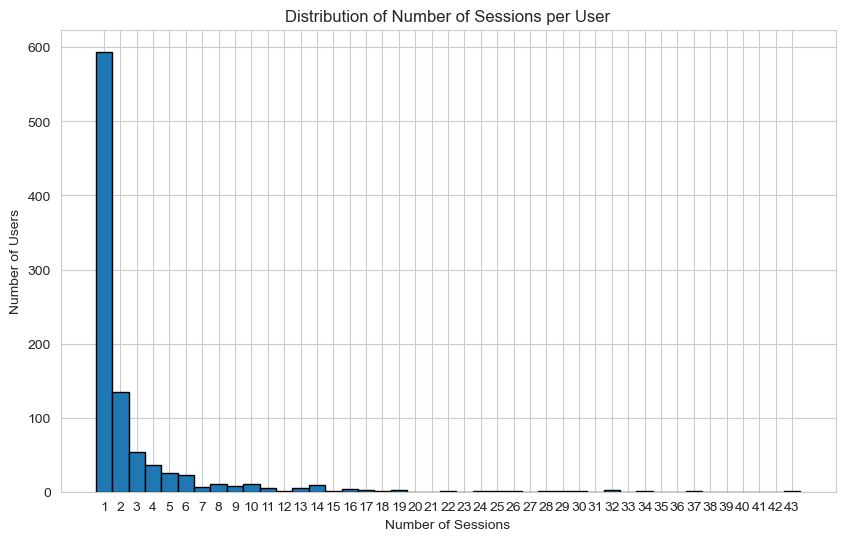

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../result_hoeffding_classifier.csv", dtype={"zip_code": str})

# Convert the 'timestamp' column to datetime if not already done
df['timestamp'] = pd.to_datetime(df['timestamp'])

# For demonstration purposes, we'll assume 'df' is already loaded and contains 'user', 'movieId', and 'timestamp'.

# Step 2: Convert timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Step 3: Extract the date from the timestamp
df['date'] = df['timestamp'].dt.date

# Step 4: Group by 'user' and 'date' and count the number of movies rated
ratings_per_session = df.groupby(['user', 'date']).size().reset_index(name='num_ratings')

# Step 5: Analyze the distribution
print("Summary Statistics:")
print(ratings_per_session['num_ratings'].describe())

# Step 6: Visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_session['num_ratings'], bins=range(1, ratings_per_session['num_ratings'].max() + 2), edgecolor='black', align='left')
plt.title('Distribution of Number of Movies Rated per User per Session')
plt.xlabel('Number of Movies Rated in a Session')
plt.ylabel('Number of Sessions')
plt.xticks(range(1, ratings_per_session['num_ratings'].max() + 1))
plt.show()

# Optional: View the counts of sessions with specific numbers of ratings
ratings_counts = ratings_per_session['num_ratings'].value_counts().sort_index()
print("\nNumber of Sessions by Number of Movies Rated:")
print(ratings_counts)

# Calculate the number of sessions per user
sessions_per_user = ratings_per_session.groupby('user').size().reset_index(name='num_sessions')

# Compute average sessions per user
average_sessions_per_user = sessions_per_user['num_sessions'].mean()
print(f"\nAverage number of sessions per user: {average_sessions_per_user:.2f}")

# Optional: Distribution of sessions per user
plt.figure(figsize=(10, 6))
plt.hist(sessions_per_user['num_sessions'], bins=range(1, sessions_per_user['num_sessions'].max() + 2), edgecolor='black', align='left')
plt.title('Distribution of Number of Sessions per User')
plt.xlabel('Number of Sessions')
plt.ylabel('Number of Users')
plt.xticks(range(1, sessions_per_user['num_sessions'].max() + 1))
plt.show()


# session durations

Description: A session is defined as a group of ratings where the gap between consecutive ratings is no more than 30 minutes (1800 seconds). If the gap exceeds 30 minutes or if it's the first rating (time_diff is NaN), a new session is started.

Summary Statistics of Session Durations (in minutes):
count    3305.000000
mean       13.265461
std        19.315023
min         0.000000
25%         0.016667
50%         6.016667
75%        17.966667
max       206.116667
Name: session_duration_min, dtype: float64


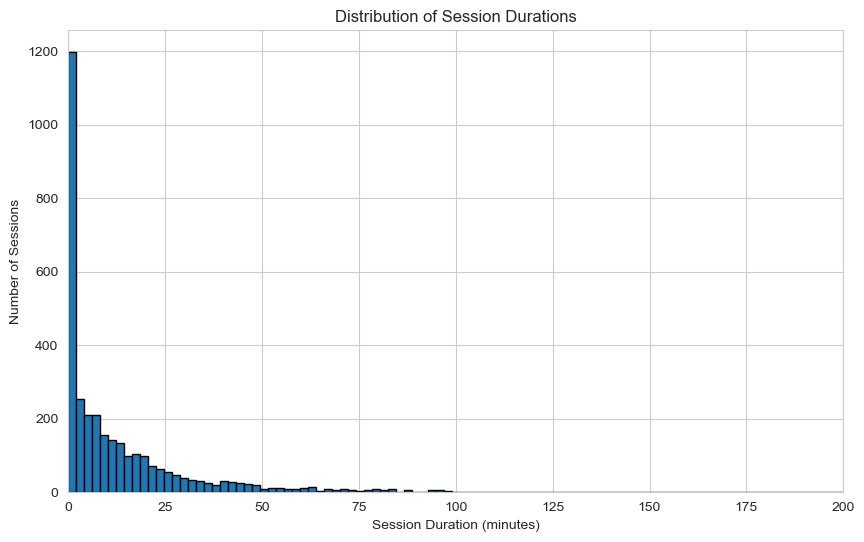


Proportion of sessions with only one rating: 19.55%


In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load your DataFrame
# df = pd.read_csv('ratings.csv')

# Step 2: Convert timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Step 3: Sort data by 'user' and 'timestamp'
df = df.sort_values(by=['user', 'timestamp']).reset_index(drop=True)

# Step 4: Calculate time differences between consecutive ratings
df['time_diff'] = df.groupby('user')['timestamp'].diff().dt.total_seconds()

# Step 5: Define sessions based on time gaps
threshold = 600  # max gap allowed
df['new_session'] = (df['time_diff'] > threshold) | (df['time_diff'].isna())
df['session_id'] = df.groupby('user')['new_session'].cumsum()

# Step 6: Calculate session durations
session_durations = df.groupby(['user', 'session_id']).agg(
    session_start=('timestamp', 'min'),
    session_end=('timestamp', 'max'),
    num_ratings=('item', 'count')
).reset_index()

session_durations['session_duration_sec'] = (session_durations['session_end'] - session_durations['session_start']).dt.total_seconds()
session_durations['session_duration_min'] = session_durations['session_duration_sec'] / 60  # Convert to minutes

# Step 7: Analyze the session durations
print("Summary Statistics of Session Durations (in minutes):")
print(session_durations['session_duration_min'].describe())

# Step 8: Visualize the session durations
plt.figure(figsize=(10, 6))
plt.hist(session_durations['session_duration_min'], bins=100, edgecolor='black')
plt.title('Distribution of Session Durations')
plt.xlabel('Session Duration (minutes)')
plt.ylabel('Number of Sessions')
plt.xlim(0, 200)  # Adjust the x-axis limit as needed
plt.show()

# Step 9: Handle sessions with single rating
single_rating_sessions = session_durations[session_durations['num_ratings'] == 1]
single_rating_sessions_ratio = len(single_rating_sessions) / len(session_durations)
print(f"\nProportion of sessions with only one rating: {single_rating_sessions_ratio:.2%}")


# Calculate the proportion of sessions with duration ≤ threshold

In [83]:

def get_session_duration_proportion(df, threshold=5):
    # Calculate the total number of sessions
    total_sessions = len(df)

    # Number of sessions with duration ≤ threshold
    sessions_leq_threshold = df[df['session_duration_min'] <= threshold]
    num_sessions_leq_threshold = len(sessions_leq_threshold)

    # Calculate the proportion
    proportion_leq_threshold = num_sessions_leq_threshold / total_sessions
    
    print("Number of sessions ≤ {} minutes: {}".format(threshold, num_sessions_leq_threshold))
    print("Proportion of sessions ≤ {} minutes: {:.2%}".format(threshold, proportion_leq_threshold))

    return total_sessions, num_sessions_leq_threshold, proportion_leq_threshold



total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=5)

# Total number of sessions
total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=10)

total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=20)


total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=40)


total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=50)


total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=60)


total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=90)


total_sessions, num_sessions, proportion_session = get_session_duration_proportion(session_durations, threshold=120)





Number of sessions ≤ 5 minutes: 1537
Proportion of sessions ≤ 5 minutes: 46.51%
Number of sessions ≤ 10 minutes: 2007
Proportion of sessions ≤ 10 minutes: 60.73%
Number of sessions ≤ 20 minutes: 2577
Proportion of sessions ≤ 20 minutes: 77.97%
Number of sessions ≤ 40 minutes: 3005
Proportion of sessions ≤ 40 minutes: 90.92%
Number of sessions ≤ 50 minutes: 3121
Proportion of sessions ≤ 50 minutes: 94.43%
Number of sessions ≤ 60 minutes: 3172
Proportion of sessions ≤ 60 minutes: 95.98%
Number of sessions ≤ 90 minutes: 3269
Proportion of sessions ≤ 90 minutes: 98.91%
Number of sessions ≤ 120 minutes: 3302
Proportion of sessions ≤ 120 minutes: 99.91%


# number of fixed windows

In [80]:
# when window size is 1 hour, i want to know how many fixed windows are there
# Set the 'timestamp' column as index (without changing the original DataFrame)
data_with_index = data.set_index('timestamp')

# Resample by 1-hour windows and count the number of fixed windows
resampled_by_hour = data_with_index.resample('H').size()

# Count the number of fixed windows (non-empty windows)
num_fixed_windows = len(resampled_by_hour[resampled_by_hour > 0])

# Output the number of fixed windows
print(f"Number of fixed 1-hour windows with data: {num_fixed_windows}")

Number of fixed 1-hour windows with data: 2222


# compare fixed window times and dynamic window times with arrival times

In [84]:
# Load data
data = pd.read_csv("../result_hoeffding_classifier.csv", dtype={"zip_code": str})
dynamic_window_times = pd.read_csv("../dynamic_window/movielens_dynamic_window_time_hoeffding_classifier_gender_dynamic_Tb_8_Tin_2_alpha_9997_time_unit_30 min.csv")
fixed_window_times = pd.read_csv("../per_item/min_as_time_unit/movielens_fixed_window_time_hoeffding_classifier_gender_per_item_alpha_9997_time_unit_30 min.csv")
fixed_window_times = fixed_window_times["fixed_window_times"].tolist()
dynamic_window_times = dynamic_window_times["dynamic_window_times"].tolist()
data_arrival_times = data["datetime"].tolist()



In [85]:
print(fixed_window_times[100:110])
print(dynamic_window_times[100:110])

['1997-09-24 09:05:10', '1997-09-24 10:05:10', '1997-09-24 11:05:10', '1997-09-24 12:05:10', '1997-09-24 13:05:10', '1997-09-24 14:05:10', '1997-09-24 15:05:10', '1997-09-24 16:05:10', '1997-09-24 17:05:10', '1997-09-24 18:05:10']
['1997-09-27 03:14:08', '1997-09-27 03:46:29', '1997-09-27 06:17:53', '1997-09-27 07:43:03', '1997-09-27 08:39:15', '1997-09-27 10:20:42', '1997-09-27 10:53:38', '1997-09-27 11:46:09', '1997-09-27 17:06:42', '1997-09-27 18:53:31']


In [91]:
from datetime import datetime
# Convert the strings to datetime objects
fixed_reset_times = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in fixed_window_times]
dynamic_reset_times = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in dynamic_window_times]
print(f"Number of fixed window resets: {len(fixed_reset_times)}")
print(f"Number of dynamic window resets: {len(dynamic_reset_times)}")


Number of fixed window resets: 5156
Number of dynamic window resets: 2271


In [92]:
# Ensure both lists are of equal length for comparison, or handle if one list is longer
min_length = min(len(fixed_reset_times), len(dynamic_reset_times))

# Calculate differences between corresponding resets
reset_diffs = [(dynamic_reset_times[i] - fixed_reset_times[i]).total_seconds() for i in range(min_length)]
print("Differences between corresponding resets (in seconds):")
print(reset_diffs)


Differences between corresponding resets (in seconds):
[3628.0, 1896.0, 35498.0, 38776.0, 38473.0, 38286.0, 38027.0, 36482.0, 35447.0, 33745.0, 31982.0, 31327.0, 37543.0, 37547.0, 38158.0, 36939.0, 42003.0, 41337.0, 39664.0, 38273.0, 37036.0, 36393.0, 49695.0, 54129.0, 52693.0, 51406.0, 49787.0, 49745.0, 48061.0, 47488.0, 105529.0, 109203.0, 107734.0, 106662.0, 106227.0, 105647.0, 108304.0, 106695.0, 115605.0, 118892.0, 130853.0, 130964.0, 151296.0, 155977.0, 155516.0, 155558.0, 154287.0, 152842.0, 151442.0, 149755.0, 153570.0, 152573.0, 151812.0, 155685.0, 154018.0, 152722.0, 159780.0, 173674.0, 181829.0, 182776.0, 182104.0, 184928.0, 184224.0, 182640.0, 185538.0, 186783.0, 185490.0, 187988.0, 188705.0, 211170.0, 239402.0, 243446.0, 243776.0, 248299.0, 247616.0, 246680.0, 245873.0, 244098.0, 243700.0, 251132.0, 250703.0, 249082.0, 249476.0, 247887.0, 247573.0, 248416.0, 249533.0, 249625.0, 247943.0, 246612.0, 246261.0, 244581.0, 245146.0, 244079.0, 243442.0, 242089.0, 240321.0, 239036

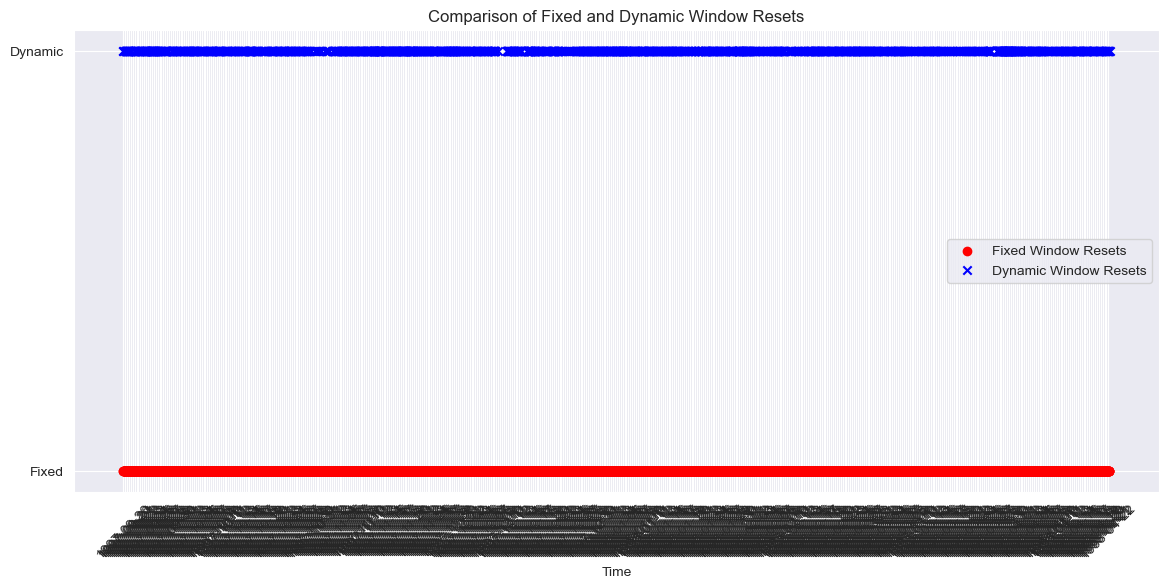

In [88]:
import matplotlib.pyplot as plt

# Convert reset times to numeric timestamps for plotting
fixed_times_numeric = [dt.timestamp() for dt in fixed_reset_times]
dynamic_times_numeric = [dt.timestamp() for dt in dynamic_reset_times]

# Create a figure
plt.figure(figsize=(14, 6))

# Plot fixed window resets as red dots on y=1
plt.scatter(fixed_times_numeric, [1] * len(fixed_times_numeric), color='red', label='Fixed Window Resets', marker='o')

# Plot dynamic window resets as blue dots on y=1.5 (so they overlap horizontally)
plt.scatter(dynamic_times_numeric, [1.5] * len(dynamic_times_numeric), color='blue', label='Dynamic Window Resets', marker='x')

# Add labels for the x-axis (time)
plt.xticks(ticks=fixed_times_numeric[::10],  # Show every 10th timestamp for readability
           labels=[dt.strftime('%Y-%m-%d') for dt in fixed_reset_times[::10]],  # Adjust to show only dates
           rotation=45)

# Add horizontal labels for fixed and dynamic windows
plt.yticks([1, 1.5], ['Fixed', 'Dynamic'])

# Label the axes
plt.xlabel('Time')
plt.title('Comparison of Fixed and Dynamic Window Resets')
plt.legend()

# Show the plot
plt.show()


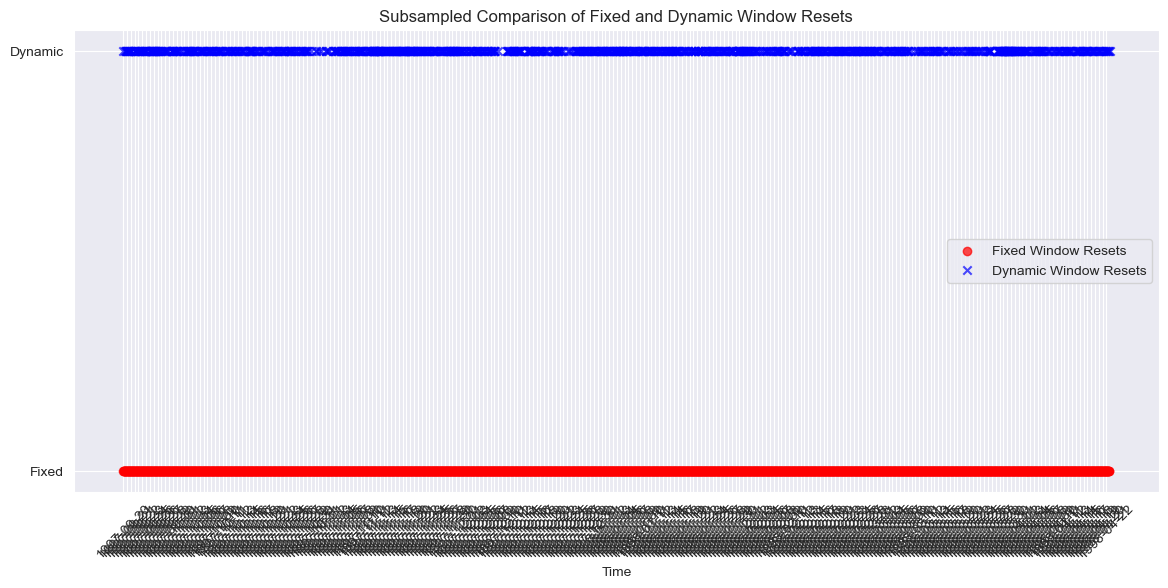

In [89]:
# Subsample to show every nth point (e.g., every 5th reset)
n = 2  # Change this value based on how much reduction you want
fixed_reset_subsample = fixed_reset_times[::n]
dynamic_reset_subsample = dynamic_reset_times[::n]

# Convert reset times to numeric timestamps for plotting
fixed_times_numeric = [dt.timestamp() for dt in fixed_reset_subsample]
dynamic_times_numeric = [dt.timestamp() for dt in dynamic_reset_subsample]

# Plot subsampled data
plt.figure(figsize=(14, 6))

plt.scatter(fixed_times_numeric, [1] * len(fixed_times_numeric), color='red', label='Fixed Window Resets', marker='o', alpha=0.7)
plt.scatter(dynamic_times_numeric, [1.5] * len(dynamic_times_numeric), color='blue', label='Dynamic Window Resets', marker='x', alpha=0.7)

plt.xticks(ticks=fixed_times_numeric[::10], labels=[dt.strftime('%Y-%m-%d') for dt in fixed_reset_subsample[::10]], rotation=45)

plt.yticks([1, 1.5], ['Fixed', 'Dynamic'])
plt.xlabel('Time')
plt.title('Subsampled Comparison of Fixed and Dynamic Window Resets')
plt.legend()
plt.show()


ValueError: The number of FixedLocator locations (258), usually from a call to set_ticks, does not match the number of ticklabels (516).

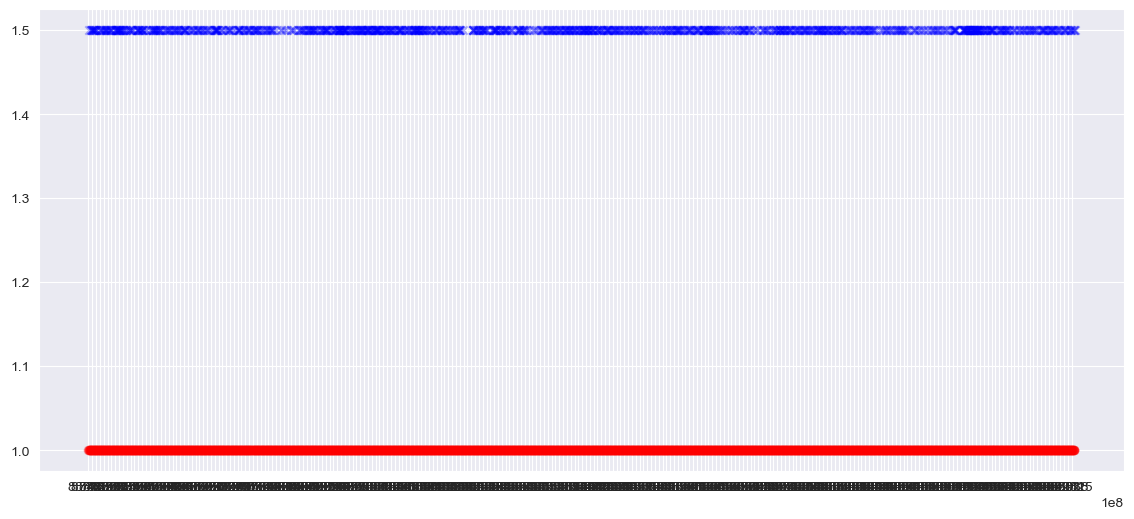

In [90]:
# Plot with transparency to handle overlaps
plt.figure(figsize=(14, 6))

# Use alpha to reduce opacity and handle overlapping dots
plt.scatter(fixed_times_numeric, [1] * len(fixed_times_numeric), color='red', label='Fixed Window Resets', marker='o', alpha=0.3)
plt.scatter(dynamic_times_numeric, [1.5] * len(dynamic_times_numeric), color='blue', label='Dynamic Window Resets', marker='x', alpha=0.3)

plt.xticks(ticks=fixed_times_numeric[::10], labels=[dt.strftime('%Y-%m-%d') for dt in fixed_reset_times[::10]], rotation=45)

plt.yticks([1, 1.5], ['Fixed', 'Dynamic'])
plt.xlabel('Time')
plt.title('Comparison of Fixed and Dynamic Window Resets with Transparency')
plt.legend()
plt.show()


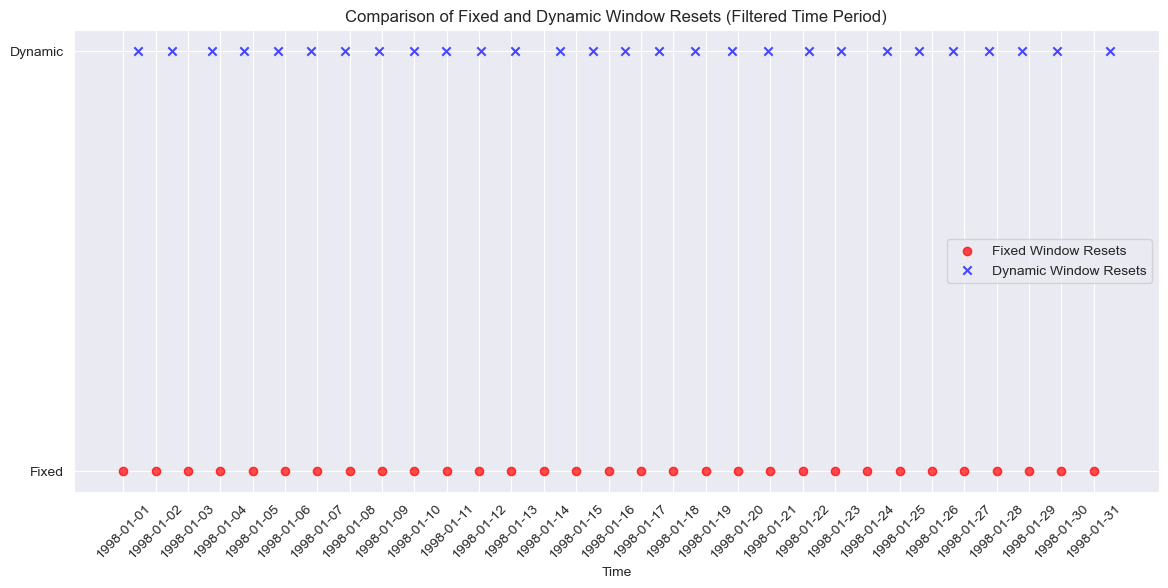

In [31]:
# Filter reset times for a specific time period (e.g., from 1998-01-01 to 1998-01-15)
start_date = datetime.strptime('1998-01-01', '%Y-%m-%d')
end_date = datetime.strptime('1998-02-01', '%Y-%m-%d')

# Filter the reset times within the desired period
fixed_filtered = [dt for dt in fixed_reset_times if start_date <= dt <= end_date]
dynamic_filtered = [dt for dt in dynamic_reset_times if start_date <= dt <= end_date]

# Convert to numeric timestamps for plotting
fixed_times_numeric = [dt.timestamp() for dt in fixed_filtered]
dynamic_times_numeric = [dt.timestamp() for dt in dynamic_filtered]

# Plot filtered data
plt.figure(figsize=(14, 6))

plt.scatter(fixed_times_numeric, [1] * len(fixed_times_numeric), color='red', label='Fixed Window Resets', marker='o', alpha=0.7)
plt.scatter(dynamic_times_numeric, [1.5] * len(dynamic_times_numeric), color='blue', label='Dynamic Window Resets', marker='x', alpha=0.7)

plt.xticks(ticks=fixed_times_numeric, labels=[dt.strftime('%Y-%m-%d') for dt in fixed_filtered], rotation=45)

plt.yticks([1, 1.5], ['Fixed', 'Dynamic'])
plt.xlabel('Time')
plt.title('Comparison of Fixed and Dynamic Window Resets (Filtered Time Period)')
plt.legend()
plt.show()


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (22).

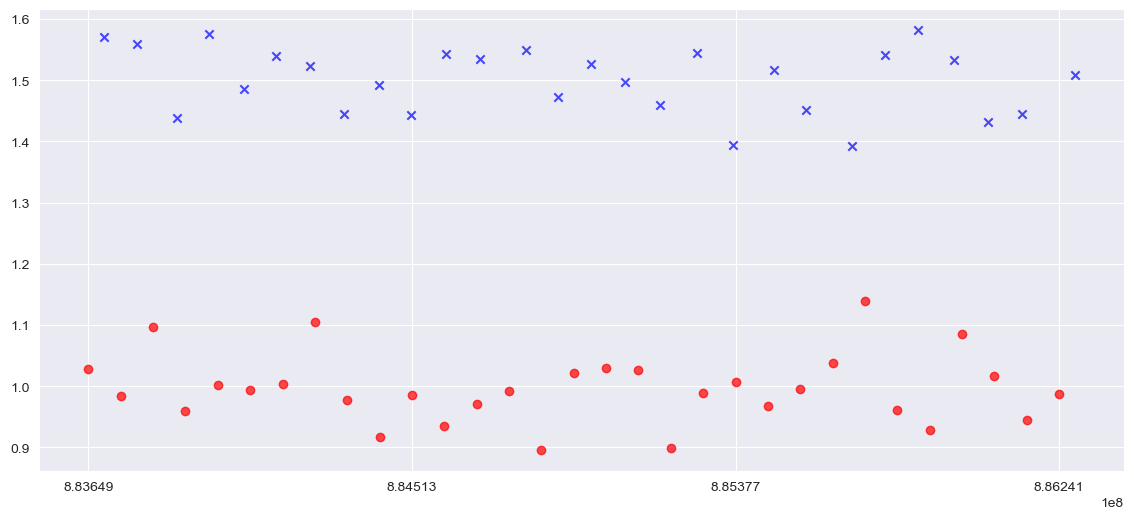

In [32]:
import numpy as np

# Add small random jitter to the y-values
fixed_jitter = 1 + np.random.normal(0, 0.05, len(fixed_times_numeric))
dynamic_jitter = 1.5 + np.random.normal(0, 0.05, len(dynamic_times_numeric))

plt.figure(figsize=(14, 6))

plt.scatter(fixed_times_numeric, fixed_jitter, color='red', label='Fixed Window Resets', marker='o', alpha=0.7)
plt.scatter(dynamic_times_numeric, dynamic_jitter, color='blue', label='Dynamic Window Resets', marker='x', alpha=0.7)

plt.xticks(ticks=fixed_times_numeric[::10], labels=[dt.strftime('%Y-%m-%d') for dt in fixed_reset_times[::10]], rotation=45)

plt.yticks([1, 1.5], ['Fixed', 'Dynamic'])
plt.xlabel('Time')
plt.title('Comparison of Fixed and Dynamic Window Resets with Jitter')
plt.legend()
plt.show()
